In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def getThetaGD(X, y, n_iter=400, alpha=1, reg=0):
    """find the solution (thetas) using the batch gradient descent"""
    m, n = X.shape
    theta = np.random.rand(n)
    Xt = X.transpose()
    for i in range(n_iter):
        h = activation(X @ theta)
        d_theta = Xt @ (h - y)
        d_theta[1:] += reg * theta[1:]
        d_theta /= m
        theta -= d_theta * alpha
    return theta

def getCostShanon(X, y, theta, reg=0):
    """calculate the cost function as the Shanon entropy"""
    m = X.shape[0]
    h = activation(X @ theta)
    J = -y @ np.log(h) - (1 - y) @ np.log(1 - h)
    if reg != 0:
        J += reg * (theta[1:] ** 2).sum() / 2
    J /= m
    return J

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


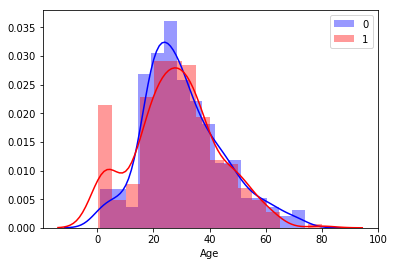

In [18]:
## data analysis
df = pd.read_csv("data/train.csv")
df.info()

## plotting
fig, fax = plt.subplots()
z = df[df.loc[:,"Survived"] == 0]["Age"]
sns.distplot(z[z.notna()], ax=fax, color="blue", label='0')
z = df[df.loc[:,"Survived"] == 1]["Age"]
sns.distplot(z[z.notna()], ax=fax, color="red", label='1')
plt.legend()

(891, 11)


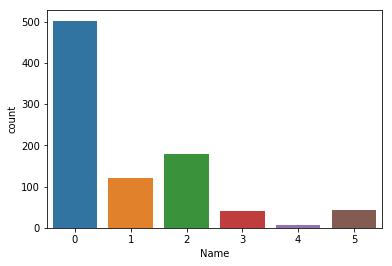

In [23]:
## mapping strings to numbers and normalizing
df.loc[:,"Sex"] = df.loc[:,"Sex"].map({"male":0, "female":1, 0:0, 1:1})
df.loc[:,"Embarked"] = df.loc[:,"Embarked"].map({'C':0, 'S':1, 'Q':2, 0:0, 1:1, 2:2})

## handling names
titleDict = {"Mr.":0, "Mrs.":1, "Miss.":2, "Master.":3, "Dr.":4}
for i_row, row in df.iterrows():
    if isinstance(row["Name"], int):
        break
    title = row["Name"].split()[1]
    if title in titleDict.keys():
        df.loc[i_row,"Name"] = titleDict[title]
    else:
        df.loc[i_row,"Name"] = len(titleDict.keys())
sns.countplot(x="Name", data=df)
        
## handling nans
df1 = df.drop(columns=["Cabin"])
df1 = df1.interpolate()
#df1 = df1.dropna()
print(df1.shape)

## creating input and output dataframes
yf = df1["Survived"]
features= ["Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
#features= ["Pclass", "Sex", "Age"]
Xf = df1[features]

## normalizing
Xf_mean, Xf_std = Xf.mean(), Xf.std()
Xf = (Xf - Xf_mean) / Xf_std
Xf.insert(0, "cst", 1.)

In [20]:
activation = sigmoid
n_iter = 1000
alpha = 0.1
reg = 10
frac_train = 0.8
m, n = Xf.shape

## gradient descent
m1_arr = np.arange(100, m, 15)
J_train_arr = []
J_test_arr = []
for m1 in m1_arr:
    print(m1)
    m1_train = int(m1 * frac_train)
    ynp_train = yf.loc[:m1_train].to_numpy()
    Xnp_train = Xf.loc[:m1_train,:].to_numpy()
    ynp_test = yf.loc[m1_train:m1].to_numpy()
    Xnp_test = Xf.loc[m1_train:m1,:].to_numpy()
    theta = getThetaGD(Xnp_train, ynp_train, n_iter, alpha, reg)
    J_train_arr.append(getCostShanon(Xnp_train, ynp_train, theta, reg))
    J_test_arr.append(getCostShanon(Xnp_test, ynp_test, theta, reg=0))

100
115
130
145
160
175
190
205
220
235
250
265
280
295
310
325
340
355
370
385
400
415
430
445
460
475
490
505
520
535
550
565
580
595
610
625
640
655
670
685
700
715
730
745
760
775
790
805
820
835
850
865
880


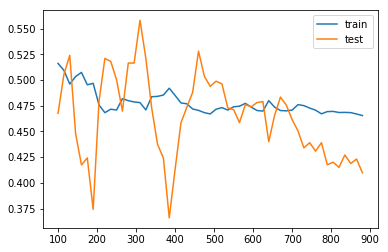

In [21]:
fig, fax = plt.subplots()
fax.plot(m1_arr, J_train_arr, label="train")
fax.plot(m1_arr, J_test_arr, label="test")
plt.legend()
plt.show()

In [36]:
hnp_train = activation(Xnp_train @ theta)
print(((hnp_train < 0.5) ^ ynp_train).sum() / ((hnp_train < 0.5) ^ ynp_train).size)
hnp_test = activation(Xnp_test @ theta)
print(((hnp_test < 0.5) ^ ynp_test).sum() / ((hnp_test < 0.5) ^ ynp_test).size)

0.8
0.8248587570621468
